# Fraud Detection with Python

We'll deal with Fraud Detection and particularly *class imbalence* which is the main challenge of fraud detection.

Contents: 
- Data Preparation
- Methods for Fraud Detection
- Evaluation (Performance) Metrics
- Labelled Data (Fraud Detection Using Supervised Learning)
- Unlabelled Data (Fraud Detection Using Unsupervised Learning)
- Text

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  VotingClassifier

from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline

## Data Preparation

In [2]:
df = pd.read_csv("datasets/creditcard_sampledata_3.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 258647 to 63421
Data columns (total 30 columns):
V1        5050 non-null float64
V2        5050 non-null float64
V3        5050 non-null float64
V4        5050 non-null float64
V5        5050 non-null float64
V6        5050 non-null float64
V7        5050 non-null float64
V8        5050 non-null float64
V9        5050 non-null float64
V10       5050 non-null float64
V11       5050 non-null float64
V12       5050 non-null float64
V13       5050 non-null float64
V14       5050 non-null float64
V15       5050 non-null float64
V16       5050 non-null float64
V17       5050 non-null float64
V18       5050 non-null float64
V19       5050 non-null float64
V20       5050 non-null float64
V21       5050 non-null float64
V22       5050 non-null float64
V23       5050 non-null float64
V24       5050 non-null float64
V25       5050 non-null float64
V26       5050 non-null float64
V27       5050 non-null float64
V28       5050 non-null

### EDA

In [4]:
df.shape

(5050, 30)

In [5]:
# Count the occurrences of fraud and no fraud
df['Class'].value_counts()

0    5000
1      50
Name: Class, dtype: int64

The ratio of fraudulent transactions is very low in Fraud Detection.

In [6]:
# Print the ratio of fraud cases
print(df['Class'].value_counts() / df['Class'].shape[0])

0    0.990099
1    0.009901
Name: Class, dtype: float64


In [7]:
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

# Create X and y from the prep_data function 
X, y = prep_data(df)

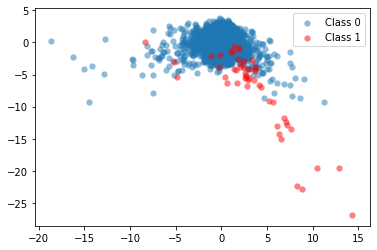

In [8]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class 0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class 1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

# Plot our data by running our plot data function on X and y
plot_data(X, y)

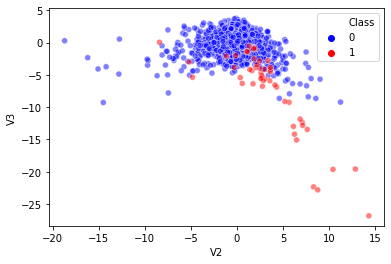

In [9]:
sns.scatterplot(x='V2', y='V3', hue='Class', palette=['b', 'r'], alpha=.5, data=df)

### Resampling Data

By using Random Over Sampling and Synthetic Minority Over-sampling Technique (SMOTE) we add more examples to the minority class. Random Under Sampling, on the other hand, adjusts the balance of the data by reducing the majority class.

#### SMOTE

SMOTE creates new, synthetic, samples of data that are quite similar to the existing observations in the minority class. It does not create exact copies of observations. 

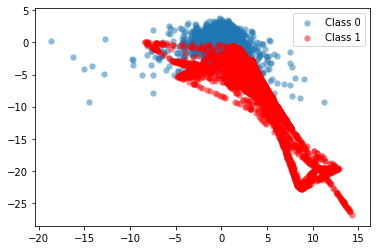

In [10]:
from imblearn.over_sampling import SMOTE

# Run the prep_data function
X, y = prep_data(df)

# Define the resampling method
method = SMOTE(kind='regular')

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [11]:
def compare_plot(X, y, X_resampled, y_resampled, method):
    # Start a plot figure
    f, (ax1, ax2) = plt.subplots(1, 2)

    # sub-plot number 1, this is our normal data
    c0 = ax1.scatter(X[y == 0, 0], X[y == 0, 1], label="Class 0",alpha=0.5)
    c1 = ax1.scatter(X[y == 1, 0], X[y == 1, 1], label="Class 1",alpha=0.5, c='r')
    ax1.set_title('Original set')
                  
    # sub-plot number 2, this is our oversampled data
    ax2.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class 0", alpha=.5)
    ax2.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class 1", alpha=.5, c='r')
    ax2.set_title(method)
    
    # some settings and ready to go
    plt.figlegend((c0, c1), ('Class 0', 'Class 1'), loc='lower center', ncol=2, labelspacing=0.)
    
    #plt.tight_layout(pad=3)
                  
    return plt.show()

0.0    5000
1.0      50
dtype: int64
1.0    5000
0.0    5000
dtype: int64


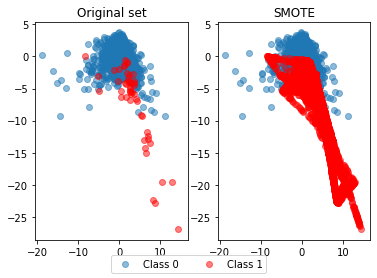

In [12]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

SMOTE balances data completely, and makes the minority class equal in size to the majority class (unless otherwise specified for parameters `sampling_strategy` or `ratio`).

## Evaluation Metrics

A confusion matrix is used to describe the performance of a classification model on a set of test data. There are several metrics that can be calculated from the confusion matrix: accuracy, precision, recall etc.

![metrics](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Preventive_Medicine_Statistics_Sensitivity_TPR%2C_Specificity_TNR%2C_PPV%2C_NPV%2C_FDR%2C_FOR%2C_ACCuracy%2C_Likelihood_Ratio%2C_Diagnostic_Odds_Ratio_2_Final.png/800px-Preventive_Medicine_Statistics_Sensitivity_TPR%2C_Specificity_TNR%2C_PPV%2C_NPV%2C_FDR%2C_FOR%2C_ACCuracy%2C_Likelihood_Ratio%2C_Diagnostic_Odds_Ratio_2_Final.png)

### Accuracy

Accuracy is the fraction of predictions our model got right. Accuracy can be misleading in the case of highly imbalanced data. 

### Precision-Recall (Confusion Matrix and Classification Report) 

The classification report tells you about the precision and recall of the model, whilst the confusion matrix actually shows how many fraud cases we can predict correctly. 

>The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

![precision-recall](https://www.kdnuggets.com/images/precision-recall-relevant-selected.jpg)


### ROC

Receiver Operating Characteristic (ROC) curve is used to assess the classifier's performance. ROC Curve shows the True Positive Rate (sensitivity, recall or probability of detection) against the False Positive Rate (probability of false alarm), and the tradeoff between sensitivity (True Positive Rate) and specificity (True Negative Rate). Thus, any increase in sensitivity will be accompanied by a decrease in specificity.

![roc](http://gim.unmc.edu/dxtests/roccomp.jpg)

### Area Under the ROC Curve (AUC)

AUC is the area under the ROC curve. When the AUC is higher, the model predicts 0s and 1s better with higher seperability. AUC is a more reliable performance evaluation metric, used to compare different classifiers. 

### Precision-Recall Curve

We can investigate the trade-off between precision and recall using Precision-recall curve, which is another tool to evaluate our model. We need a balance between these two in the model.

## Methods for Fraud Detection

### Rule Based Methods (Using Statistical Thresholds)

We'll define _threshold_ values using statistics, to split fraud and non-fraud. Then, we'll use those thresholds on the features to detect fraud.

In [13]:
# Get the mean for each group
df.groupby('Class').mean()

# Implement a rule for stating which cases are flagged as fraud
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 <-3, df.V3<-5), 1, 0)

# Create a crosstab of flagged fraud cases versus the actual fraud cases
print(pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              4984  16
1                28  22


### ML Classification Methods (Logistic Regression Example)

#### Logistic Regression w/o SMOTE

In [14]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the confusion matrix and classifcation report
print('Confusion matrix:\n', confusion_matrix(y_true=y_test, y_pred=predicted))
print('\nClassification report:\n', classification_report(y_test, predicted))

Confusion matrix:
 [[1504    1]
 [   2    8]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Logistic Regression w/ SMOTE

In [15]:
# from imblearn.pipeline import Pipeline

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(kind='borderline2')
model = LogisticRegression()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), 
                     ('Logistic Regression', model)])

In [16]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Confusion matrix:\n', confusion_matrix(y_true=y_test, y_pred=predicted))
print('\nClassification report:\n', classification_report(y_test, predicted))

Confusion matrix:
 [[1499    6]
 [   0   10]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.62      1.00      0.77        10

    accuracy                           1.00      1515
   macro avg       0.81      1.00      0.88      1515
weighted avg       1.00      1.00      1.00      1515



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


It seems that SMOTE slightly improves the results. However, we should keep in mind that resampling may not necessarily lead to better results in every case.
>  When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly. 

## Labelled Data

In this section, we'll flag fraudulent transactions using supervised learning.

In [17]:
df = pd.read_csv("datasets/creditcard_sampledata_2.csv", index_col=0)

In [18]:
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

# Create X and y from the prep_data function 
X, y = prep_data(df)

In [19]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

95.8904109589041


The **natural accuracy** (or baseline accuracy or hit rate) is roughly 96%. If we get an accuracy of less than this number, the model does not actually add any value in predicting how many cases are correct.

### Random Forest Classifier

Random Forest is better suited to Fraud Detection than Decision Trees, since it prevents overfitting most of the time.

#### Baseline Model

In [24]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))
# print(model.score(X_test, y_test)) (same as above code)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9904109589041096


In [26]:
# Obtain the predictions from the random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

0.9338879319822626
[[2096    3]
 [  18   73]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.96      0.80      0.87        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.93      2190
weighted avg       0.99      0.99      0.99      2190



In [28]:
sum(y_test)

91.0

The model predicts 76 cases of fraud, out of which 73 are true positives (actual fraud) and 3 are false positives. The model does not catch 18 cases of actual fraud. Recall is therefore not as good as precision. 
![](https://3.bp.blogspot.com/--jLXutUe5Ss/VvPIO6ZH2tI/AAAAAAAACkU/pvVL4L-a70gnFEURcfBbL_R-GnhBR6f1Q/s1600/ConfusionMatrix.png)

Text(0.5, 1.0, 'Precision-Recall Curve')

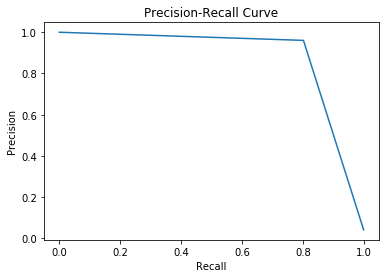

In [43]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the ROC curve
plt.plot(recall, precision)

# Set the labels and the title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

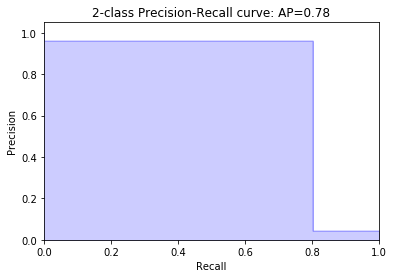

In [41]:
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision)) 
    plt.show()
    
# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

#### Adjusting the Model

We can use `class_weight` parameter in our `classsifier` to deal with highly imbalanced fraud data. We can either choose “balanced” or “balanced_subsample”.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)) 

> The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [49]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

0.9347962661445273
[[2098    1]
 [  19   72]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.99      0.79      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The model results does not appear to improve drastically after changing the `class_weight` parameter.

In [72]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',
                                # Change depth of model
                                max_depth=10,
                                # Change the number of samples in leaf nodes
                                min_samples_leaf=10, 
                                # Change the number of trees to use
                                n_estimators=20, n_jobs=-1, random_state=5)


In [96]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
#    probs = model.predict_proba(X_test)
    print (confusion_matrix(y_test, predicted))
    print (classification_report(y_test, predicted))


# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

[[2052   47]
 [  11   80]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2099
         1.0       0.63      0.88      0.73        91

    accuracy                           0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Grid Search


For fraud detection we are mostly interested in catching as many fraud cases as possible. Therefore we'll adjust the  model settings to get the best possible Recall score. We can also choose to optimize F1-Score to get a Precision-Recall trade-off and reduce the number of false positives. Grid Search will help us to investigate a range of Hyperparameters.

In [87]:
# Define the parameter sets to test
param_grid = {'n_estimators': [10, 20, 30], 
              'max_features': ['auto', 'log2'],  
              'max_depth': [4, 8, 10], 
              'min_samples_leaf': [1, 10, 20], 
              'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier(class_weight={0:1, 1:12}, random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'n_estimators': 10}

In [88]:
CV_model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 12},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=5, verbose=0, warm_start=False)

In [89]:
CV_model.best_score_

0.8562146141450231

In [90]:
# Change the model options
model = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini',
                                max_depth=4, min_samples_leaf=20, max_features= 'auto',
                                n_estimators=20, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

[[2090    9]
 [  14   77]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2099
         1.0       0.90      0.85      0.87        91

    accuracy                           0.99      2190
   macro avg       0.94      0.92      0.93      2190
weighted avg       0.99      0.99      0.99      2190



#### Ensembling

We can combine different algorithms/classifiers into one model to improve performance and to have a robost model. `VotingClassifier` is an option for ensembling.

For instance, the Logistic Regression may be worse in terms of false positives, and the Random Forest may be worse in terms of false negatives. By combining these together we may have a chance to improve performance.

In [104]:
# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:12}, random_state=5)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

[[2060   39]
 [  13   78]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2099
         1.0       0.67      0.86      0.75        91

    accuracy                           0.98      2190
   macro avg       0.83      0.92      0.87      2190
weighted avg       0.98      0.98      0.98      2190



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression model has a better recall, however more false positives. Ensembling it with Random Forest might be useful.

In [105]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:12}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight={0:1, 1:12})

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[2091    8]
 [  15   76]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2099
         1.0       0.90      0.84      0.87        91

    accuracy                           0.99      2190
   macro avg       0.95      0.92      0.93      2190
weighted avg       0.99      0.99      0.99      2190



#### Adjusting Voting Classifier

We can adjust the `weights` we give to the models with Voting Classifier. If we think that a particular model is more important than the others, we can give it a higher weight relative to the others. With trying different weights, we can find a good mix for the model.

In [106]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results a
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[2095    4]
 [  15   76]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2099
         1.0       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190



## Unlabelled Data

In this section, we'll flag fraudulent transactions using unsupervised learning. Customer segmentation and clustering algorithms will be used.

## Text